# load dataset

In [22]:
# Download Kaggle API token from Google Drive
gdrive_url = 'https://drive.google.com/uc?id=1P6t7O8vOjmQi3rMX0KQlgO6BT0fk2dI-'
import gdown
if not os.path.exists('kaggle.json'):
    gdown.download(gdrive_url, 'kaggle.json', quiet=False)

# Configure the Kaggle API
import os
from pathlib import Path

kaggle_dir = Path.home() / '.kaggle'
kaggle_token_path = kaggle_dir / 'kaggle.json'

if not kaggle_token_path.exists():
    # Create the .kaggle directory if it does not exist
    kaggle_dir.mkdir(parents=True, exist_ok=True)

    # Move the kaggle.json to ~/.kaggle/
    os.rename('kaggle.json', kaggle_token_path)

    # Set the permissions to read and write for the user only
    kaggle_token_path.chmod(0o600)

dataset_path = 'A_Z Handwritten Data.csv'

if not os.path.exists(dataset_path):
    # Download the dataset from Kaggle
    kaggle_remote_path = 'sachinpatel21/az-handwritten-alphabets-in-csv-format'
    !kaggle datasets download -d {kaggle_remote_path} --unzip

import pandas as pd
data = pd.read_csv(dataset_path)
display(data.head())
print('data shape:', data.shape)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


data shape: (372450, 785)


In [23]:
# Define the kana characters and their corresponding labels
letters = [chr(i) for i in range(65, 91)]
print(letters)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## perform CNN

In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import matplotlib.pyplot as plt # plotting
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [25]:
num_samples = 372450
num_classes = 26  # Number of letters in the alphabet

# data.insert(0, 'alphabet', np.random.randint(0, num_classes, size=num_samples))

# Add column names
columns = ['alphabet'] + [f'pixel_{i}' for i in range(1, 785)]
data.columns = columns
data.columns

Index(['alphabet', 'pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5',
       'pixel_6', 'pixel_7', 'pixel_8', 'pixel_9',
       ...
       'pixel_775', 'pixel_776', 'pixel_777', 'pixel_778', 'pixel_779',
       'pixel_780', 'pixel_781', 'pixel_782', 'pixel_783', 'pixel_784'],
      dtype='object', length=785)

In [26]:
from tensorflow.keras.utils import to_categorical

# X = np.random.randint(0, 256, size=(num_samples, 784))
# y = np.random.randint(0, num_classes, size=(num_samples,))
# X = X.reshape(-1, 28, 28, 1)
# X = X / 255.0
# y = to_categorical(y, num_classes)
y = data['alphabet']
X = data.drop('alphabet', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape,

((260715, 784), (111735, 784))

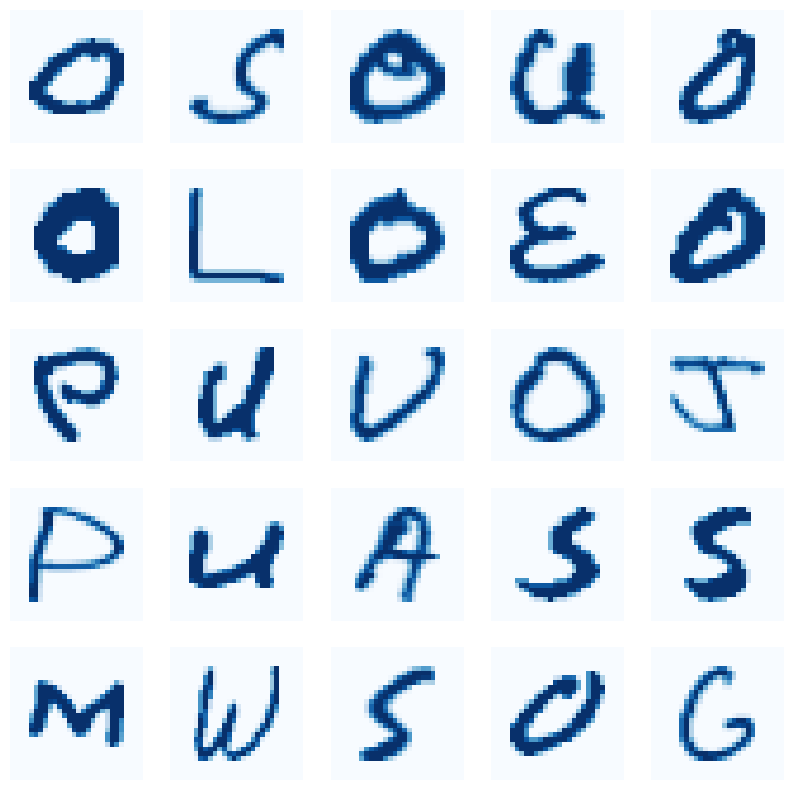

In [28]:
import numpy as np

random_indices = np.random.choice(range(len(X)), size=25, replace=False)
_, axes = plt.subplots(5, 5, figsize=(10, 10))
for i,ax in enumerate(axes.ravel()):
    ax.imshow(X.iloc[random_indices[i]].values.reshape(28, 28), cmap='Blues')
    ax.axis('off')
plt.show()

In [29]:
# model with 1d convolution

from tensorflow.keras import layers

cnn = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Reshape((X_train.shape[1], 1)),  # Reshape to (784, 1)
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
], name='one_dimensional_cnn')
cnn.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
cnn.summary()

# Train the model
history_cnn = cnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
history_cnn.history['name'] = cnn.name

# Evaluate the model
test_loss, test_accuracy = cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

c:\ProgramData\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10


c:\ProgramData\miniconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8148/8148 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4995 - loss: 2.1610

c:\ProgramData\miniconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8148/8148 ━━━━━━━━━━━━━━━━━━━━ 220s 27ms/step - accuracy: 0.4995 - loss: 2.1609 - val_accuracy: 0.9207 - val_loss: 0.2946
Epoch 2/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 248s 30ms/step - accuracy: 0.8359 - loss: 0.5535 - val_accuracy: 0.9516 - val_loss: 0.1710
Epoch 3/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 226s 28ms/step - accuracy: 0.8976 - loss: 0.3514 - val_accuracy: 0.9623 - val_loss: 0.1346
Epoch 4/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 185s 23ms/step - accuracy: 0.9207 - loss: 0.2701 - val_accuracy: 0.9677 - val_loss: 0.1157
Epoch 5/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 184s 23ms/step - accuracy: 0.9347 - loss: 0.2215 - val_accuracy: 0.9715 - val_loss: 0.1031
Epoch 6/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 186s 23ms/step - accuracy: 0.9435 - loss: 0.1882 - val_accuracy: 0.9738 - val_loss: 0.0950
Epoch 7/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 187s 23ms/step - accuracy: 0.9487 - loss: 0.1695 - val_accuracy: 0.9756 - val_loss: 0.0902
Epoch 8/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 199s 24ms/step - accuracy: 0.9534 - lo

In [30]:
# multilayer perceptron without convolution

mlp = tf.keras.models.Sequential(name='multilayer_perceptron')
mlp.add(layers.InputLayer(shape=(X_train.shape[1],)))
mlp.add(layers.Dense(128, activation='relu'))
mlp.add(layers.Dense(64, activation='relu'))
mlp.add(layers.Dense(26, activation='linear'))
mlp.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
mlp.summary()

# Evaluate untrained model
test_loss, test_accuracy = mlp.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,426 (431.35 KB)

 Trainable params: 110,426 (431.35 KB)

 Non-trainable params: 0 (0.00 B)

3492/3492 ━━━━━━━━━━━━━━━━━━━━ 3s 773us/step - accuracy: 0.0545 - loss: 150.5012
Test Accuracy: 5.50%


In [32]:
history_mlp = mlp.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
history_mlp.history['name'] = cnn.name

# Evaluate the model after training
test_loss, test_accuracy = mlp.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9688 - loss: 0.1081 - val_accuracy: 0.9630 - val_loss: 0.1449
Epoch 2/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9715 - loss: 0.0989 - val_accuracy: 0.9638 - val_loss: 0.1435
Epoch 3/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9733 - loss: 0.0921 - val_accuracy: 0.9658 - val_loss: 0.1373
Epoch 4/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9751 - loss: 0.0846 - val_accuracy: 0.9676 - val_loss: 0.1318
Epoch 5/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9764 - loss: 0.0814 - val_accuracy: 0.9672 - val_loss: 0.1331
Epoch 6/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9778 - loss: 0.0750 - val_accuracy: 0.9683 - val_loss: 0.1322
Epoch 7/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.9783 - loss: 0.0721 - val_accuracy: 0.9681 - val_loss: 0.1307
Epoch 8/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.9800 - loss: 0

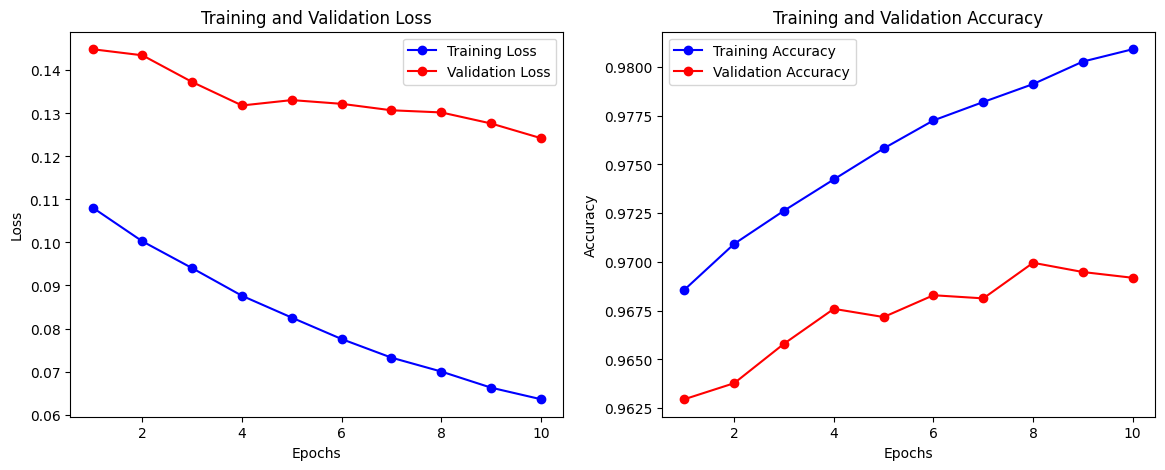

In [33]:
for history in [history_mlp, history_cnn]:
    # Extracting loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Plotting training and validation loss
    plt.figure(figsize=(14, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()